# Import necessary libraries


# Sentiment Analysis on Twitter Data using Deep Learning
# Author: [Ahmed Osman]
"""

Here's an overview of the main techniques and components used in this project:

1. Data Preprocessing:
   - Text cleaning using regular expressions
   - Handling of URLs, usernames, and emojis
   - Contraction expansion
   - Lowercasing and special character removal

2. Text Representation:
   - Word2Vec: Used for creating word embeddings
   - Tokenization: Converting text to sequences of integers

3. Data Visualization:
   - Bar plots for sentiment distribution
   - Word clouds for positive and negative sentiments

4. Deep Learning Model:
   - Architecture: Bidirectional LSTM layers followed by Conv1D and Dense layers
   - Embedding layer initialized with pre-trained Word2Vec embeddings
   - Binary classification (positive/negative sentiment)

5. Model Training and Evaluation:
   - Use of callbacks: ReduceLROnPlateau and EarlyStopping
   - Visualization of training history (accuracy and loss)
   - Confusion matrix and classification report for model evaluation

6. Additional Techniques:
   - Data splitting using train_test_split
   - Sequence padding for uniform input length
   - Model and data saving for future use

This notebook provides a step-by-step implementation of these techniques, along with explanations and visualizations to aid understanding. By the end, you'll have a trained model capable of predicting sentiment in tweet-like text data.
"""



In [44]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import nltk
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import pickle
import os 
# Visualization libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Deep learning libraries
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Download necessary NLTK resources


In [2]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load the dataset

In [3]:
# Download the dataset from Kaggle
# Note: You need to have kaggle CLI configured with your API key
!kaggle datasets download -d kazanova/sentiment140
!unzip sentiment140.zip

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)


#g

In [4]:
# In this step, we are trying to read the data 
# The dataset is being read from a CSV file using the 'ISO-8859-1' encoding, as it includes special characters not supported by the default 'utf-8' encoding.
# The columns have been named accordingly for easier reference during data analysis.
# This initial data loading helps us understand the structure of the dataset before we proceed with preprocessing and modeling tasks.

DATASET_COLUMNS = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
dataset.head()


,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]

# Replacing the values.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

<ipython-input-5-11adef286a16>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['sentiment'] = dataset['sentiment'].replace(4,1)


Visualizing Sentiment Distribution

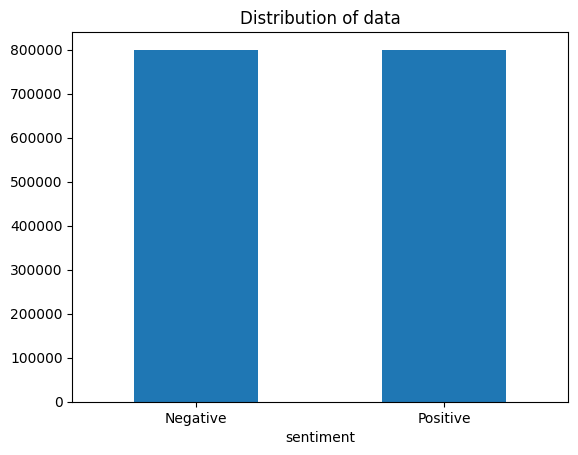

In [6]:
#In this step, we are creating a bar plot to visualize the distribution of sentiment labels (positive and negative) in the dataset.
#We group the dataset by the 'sentiment' column and count the number of entries for each sentiment class.
#This plot provides an overview of how balanced or imbalanced the dataset is, which is crucial for model training and performance evaluation.#
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',legend=False)
ax = ax.set_xticklabels(['Negative','Positive'], rotation=0)

Preprocessing Tweets for Text Analysis.

This cell handles multiple text preprocessing steps crucial for cleaning and standardizing raw tweet data, making it suitable for NLP tasks:

In [8]:
# 1. We load a 'contractions.csv' file containing common contractions and their expanded meanings. We convert this to a dictionary for quick lookup and replacement.

contractions = pd.read_csv('/content/contractions (1).csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']


# 2. We define several regex patterns for handling URLs, usernames, hashtags, repeated character sequences, and emojis, allowing us to generalize and clean noisy data.

urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"


# 3. In the 'preprocess_apply' function, each tweet is processed by:
#    - Converting text to lowercase to ensure consistency.
#    - Replacing URLs, user mentions, and specific emoji patterns with placeholders to preserve semantic meaning.
#    - Expanding contractions to their full forms for better model understanding.
#    - Normalizing repeated characters (e.g., "soooo" to "soo") to avoid redundant characters influencing the model.
#    - Finally, removing non-alphanumeric characters and ensuring proper spacing around slashes.
# This function prepares the text for tokenization and feature extraction, improving the quality of downstream NLP tasks like sentiment analysis.

def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URLs with '<url>'.
    tweet = re.sub(urlPattern, '<url>', tweet)
    # Replace @USERNAME with '<user>'.
    tweet = re.sub(userPattern, '<user>', tweet)

    # Replace 3 or more consecutive letters with 2 letters.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis with corresponding placeholders.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    # Expand contractions using the contractions dictionary.
    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric characters.
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Add space around slashes for better separation of words.
    tweet = re.sub(r'/', ' / ', tweet)

    return tweet


In [9]:
# In this step, we apply the 'preprocess_apply' function to each tweet in the dataset using the 'apply' method.
# The cleaned text is stored in a new column, 'processed_text', which will be used for further analysis and modeling.
# Using '%%time' allows us to track the execution time for this operation, which is useful for performance evaluation when working with large datasets.

%%time
dataset['processed_text'] = dataset.text.apply(preprocess_apply)


CPU times: user 1min 31s, sys: 379 ms, total: 1min 31s
Wall time: 1min 33s


Displaying Sample Original and Processed Tweets


In [10]:
# In this cell, we are iterating over the dataset using the 'itertuples()' method, which returns each row as a named tuple.
# The goal is to compare the original text (raw tweets) and the processed text (cleaned tweets) side by side.
# we use a counter to display only the first 10 tweets.

count = 0
for row in dataset.itertuples():
    print("Text:", row[2])
    print("Processed:", row[3])
    if count > 10:
        break


Text: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Processed: <user> <url>   aww  thatis a bummer   you shoulda got david carr of third day to do it  <smile>
Text: is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
Processed: is upset that he cannot update his facebook by texting it   and might cry as a result  school today also  blah 
Text: @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
Processed: <user> i dived many times for the ball  managed to save 50   the rest go out of bounds
Text: my whole body feels itchy and like its on fire 
Processed: my whole body feels itchy and like its on fire 
Text: @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
Processed: <user> no  it is not behaving at all  i am mad  why am i here  because i cannot see you all ov

Splitting Processed Text into Positive and Negative Classes


In [11]:
# The 'processed_text' column is first converted into a list for easy manipulation.
# We split the list accordingly:
# - 'data_neg' stores the first 800,000 entries, which are negative sentiment tweets.
# - 'data_pos' stores the remaining entries (from 800,000 onward), representing positive sentiment tweets.

processedtext = list(dataset['processed_text'])
data_pos = processedtext[800000:]
data_neg = processedtext[:800000]


Generating and Visualizing a Word Cloud for Positive Sentiment Tweets

This visualization helps in understanding the most frequent words used in positive sentiment tweets, giving insights into the overall language and tone.


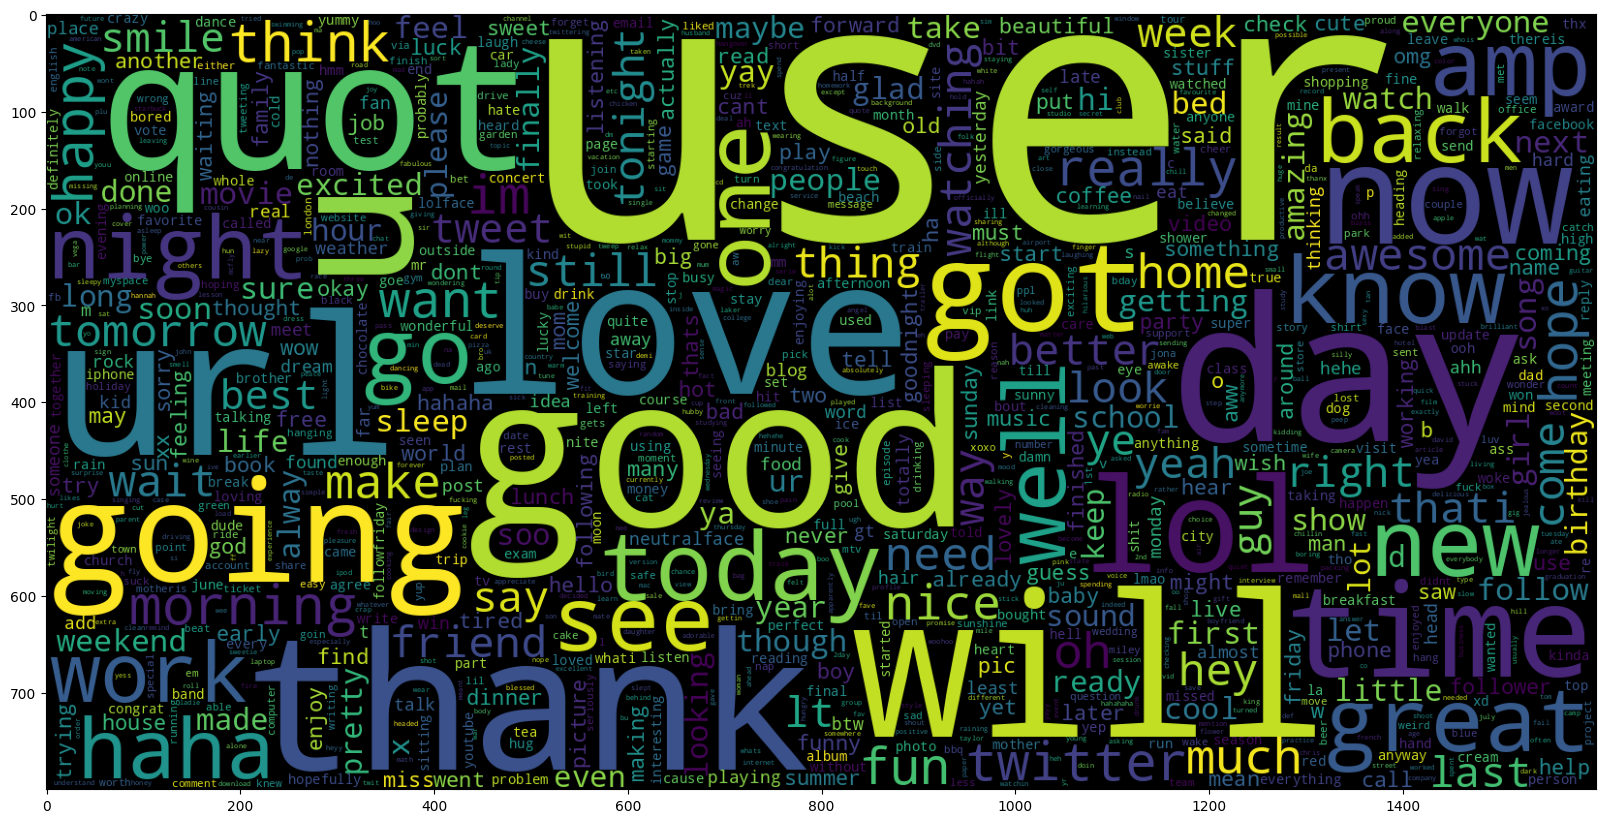

In [45]:
# The 'data_pos' list, which contains preprocessed positive tweets, is joined into a single string to be used as input for the word cloud.
# The 'WordCloud' object is configured with:
# - max_words = 1000: The maximum number of words to display in the cloud.
# - width and height: The size of the output image.
# - collocations=False: To ensure that words are displayed individually rather than as bigrams or combinations.

wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)


Generating and Visualizing a Word Cloud for Negative Sentiment Tweets

This visualization helps in understanding the most frequent words used in Negative sentiment tweets, giving insights into the overall language and tone.


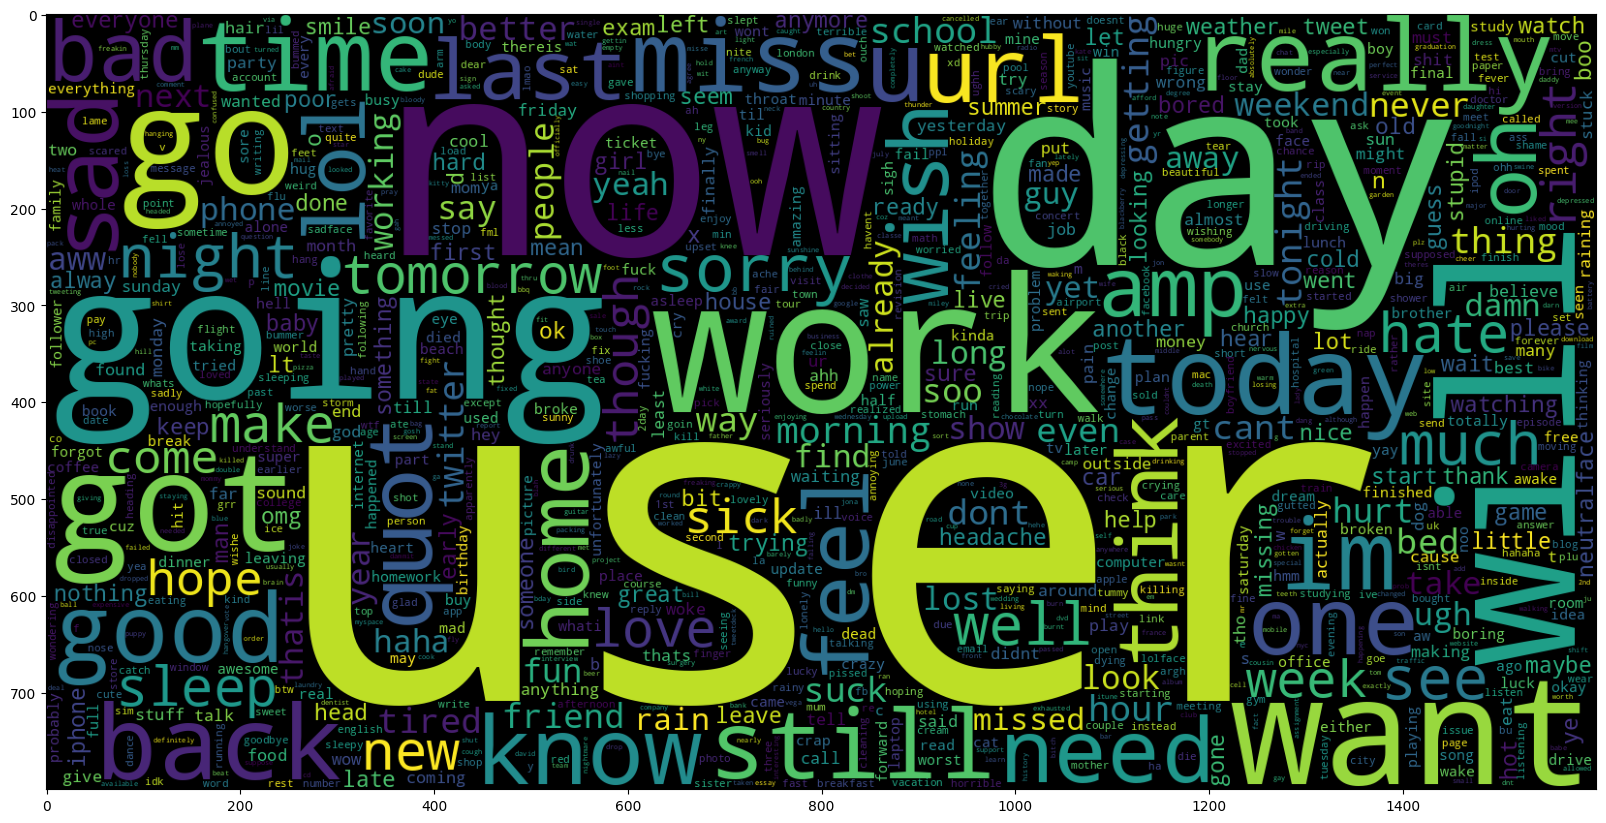

In [46]:
# The 'data_neg' list, which contains preprocessed positive tweets, is joined into a single string to be used as input for the word cloud.

wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,collocations=False).generate(" ".join(data_neg))
plt.figure(figsize = (20,20))
plt.imshow(wc)

Splitting Data into Training and Testing Sets


In [12]:
# We use 'train_test_split' to divide the processed text (X_data) and corresponding sentiments (y_data) into training and testing sets

from sklearn.model_selection import train_test_split
X_data, y_data = np.array(dataset['processed_text']), np.array(dataset['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.05, random_state = 0)
print('Data Split done.')


Data Split done.


Preparing Data for Word2Vec Embedding


In [13]:
# In this step, we prepare the training data for the Word2Vec model by splitting each sentence in 'X_train' into individual words.
# This is done using the 'map' function, which applies the 'split()' method to each processed tweet.

from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))


Training the Word2Vec Model

This model is essential for capturing semantic relationships between words in the dataset.


In [14]:
%%time

# In this cell, we define and train the Word2Vec model using the prepared training dataset ('Word2vec_train_data').
# Key parameters include:
# - vector_size: Sets the dimensionality of the word embeddings (100 dimensions).
# - workers: Specifies the number of CPU cores to use for training (8).
# - min_count: Ignores all words with a total frequency lower than this value (5), ensuring that only significant words are included in the vocabulary.
# After training, we print the vocabulary length, which indicates how many unique words were learned by the model.

word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))


Vocabulary Length: 52025
CPU times: user 3min 43s, sys: 1.28 s, total: 3min 44s
Wall time: 2min 34s


Initializing and Fitting the Tokenizer

This step is crucial for preparing the data for input into machine learning models.


In [16]:
# create a tokenizer to convert text data into sequences of integers.
# Key configurations include:
# - filters="": Disables the default filtering of punctuation and special characters.
# - lower=False: Retains the original case of the text.
# - oov_token="<oov>": Specifies a token for out-of-vocabulary words.
# The tokenizer is then fitted on the entire dataset ('X_data'), allowing it to learn the unique words.
# We also set 'num_words' to a predefined vocabulary length (60,000) to limit the tokenizer to the most frequent words.

vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)


Tokenizer vocab length: 60000


Padding Sequences for Consistent Input Length

This ensures that all input sequences have the same length, which is essential for training machine learning models.



In [17]:
# I convert the tokenized text sequences into padded sequences using 'pad_sequences'.
# - tokenizer.texts_to_sequences(X_train): Converts the texts in 'X_train' into sequences of integers based on the fitted tokenizer.
# - maxlen=input_length: Specifies the maximum length of the padded sequences. Any sequence longer than this will be truncated, and shorter sequences will be padded with zeros.
# The same process is applied to 'X_test' for consistency.

# Defining the model input length.
input_length = 60


X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)


X_train.shape: (1520000, 60)
X_test.shape : (80000, 60)


Creating the Embedding Matrix

This embedding matrix will be used to initialize the embedding layer in our neural network, allowing it to utilize pre-trained word embeddings.



In [18]:
# This step initializing an embedding matrix to hold the word embeddings for the vocabulary.
# The matrix is of shape (vocab_length, Embedding_dimensions) where:
# - vocab_length: The number of unique words (60,000).
# - Embedding_dimensions: The dimensionality of the word embeddings (100 dimensions).
# I then populate the embedding matrix with vectors from the Word2Vec model for each word in the tokenizer's word index.
# The 'if' condition checks if the word exists in the Word2Vec model's vocabulary.

embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)


Embedding Matrix Shape: (60000, 100)


Building the Sentiment Analysis Model

This function defines and returns a Sequential model for sentiment analysis using deep learning techniques.

In [20]:
def getModel():

    # Embedding Layer:
    # - input_dim: The size of the vocabulary (60,000).
    # - output_dim: The dimensionality of the word embeddings (100).
    # - weights: The pre-trained embedding matrix to initialize the layer.
    # - input_length: The length of input sequences.
    # - trainable: Set to False to prevent updating the embeddings during training.
    embedding_layer = Embedding(input_dim=vocab_length,
                                output_dim=Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    # Model Architecture:
    model = Sequential([
        embedding_layer,  # First layer with embeddings
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),  # Bidirectional LSTM for capturing sequential dependencies
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),  # Second Bidirectional LSTM
        Conv1D(100, 5, activation='relu'),  # Convolutional layer for feature extraction
        GlobalMaxPool1D(),  # Global max pooling to reduce dimensionality
        Dense(16, activation='relu'),  # Dense layer for further learning
        Dense(1, activation='sigmoid'),  # Output layer for binary classification (positive/negative sentiment)
    ],
    name="Sentiment_Model")
    
    return model  # Return the constructed model


Initializing and Summarizing the Sentiment Analysis Model


In [21]:

training_model = getModel()  # Initialize the model
training_model.summary()  # Print the summary of the model architecture


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "Sentiment_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       6,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,000,000 (22.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,000,000 (22.89 MB)

Defining Callbacks for Training


In [22]:
# sets up two callbacks to enhance the training process :
# 1. ReduceLROnPlateau: 
#    - Monitors the validation loss ('val_loss').
#    - Reduces the learning rate when a plateau in validation loss is detected, helping to fine-tune learning in later epochs.
#    - 'patience': Number of epochs with no improvement after which the learning rate will be reduced.
#    - 'cooldown': Number of epochs to wait before resuming normal operation after the learning rate has been reduced.
# 2. EarlyStopping:
#    - Monitors the validation accuracy ('val_accuracy').
#    - Stops training if the validation accuracy does not improve for a specified number of epochs ('patience').
#    - 'min_delta': Minimum change in the monitored quantity to qualify as an improvement.

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
    EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)
]


In [23]:
#compile
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Training Progress Summary,
The model has shown consistent improvement over the 12 epochs:

- Accuracy increased from 77.35% to 84.14% on the training set.

- Validation accuracy rose from 81.27% to 83.50%, with validation loss decreasing throughout.

This indicates that the model is learning effectively. 

To further enhance performance, consider increasing the number of epochs, which may help achieve even higher accuracy and better generalization.


In [26]:
# fitting
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=12,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/12
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 174s 126ms/step - accuracy: 0.7735 - loss: 0.4689 - val_accuracy: 0.8127 - val_loss: 0.4083 - learning_rate: 0.0010
Epoch 2/12
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 174s 130ms/step - accuracy: 0.8147 - loss: 0.4033 - val_accuracy: 0.8204 - val_loss: 0.3944 - learning_rate: 0.0010
Epoch 3/12
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 200s 129ms/step - accuracy: 0.8229 - loss: 0.3893 - val_accuracy: 0.8248 - val_loss: 0.3859 - learning_rate: 0.0010
Epoch 4/12
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 202s 129ms/step - accuracy: 0.8273 - loss: 0.3810 - val_accuracy: 0.8277 - val_loss: 0.3835 - learning_rate: 0.0010
Epoch 5/12
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 200s 128ms/step - accuracy: 0.8313 - loss: 0.3747 - val_accuracy: 0.8295 - val_loss: 0.3785 - learning_rate: 0.0010
Epoch 6/12
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 202s 128ms/step - accuracy: 0.8331 - loss: 0.3702 - val_accuracy: 0.8314 - val_loss: 0.3756 - learning_rate: 0.0010
Epoch 7/12
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 206s 131ms

Plotting Training and Validation Metrics

The following code visualizes the training and validation accuracy and loss over epochs.

- The first plot displays the training accuracy (in blue) and validation accuracy (in red),
allowing us to observe the model's performance over time.

- The second plot shows the training loss (in blue) and validation loss (in red),
which helps us understand how well the model is fitting the data and whether it is overfitting.

This visualization aids in evaluating the model's training process and making adjustments if necessary.


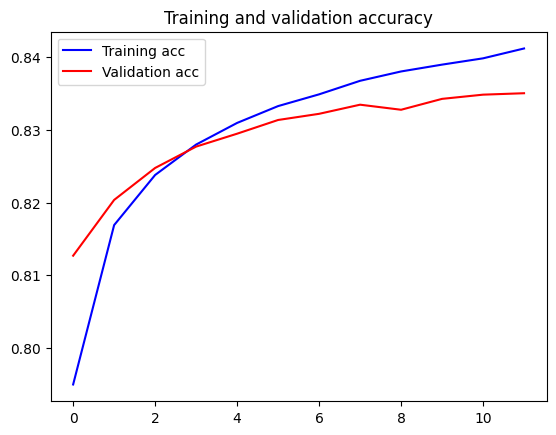

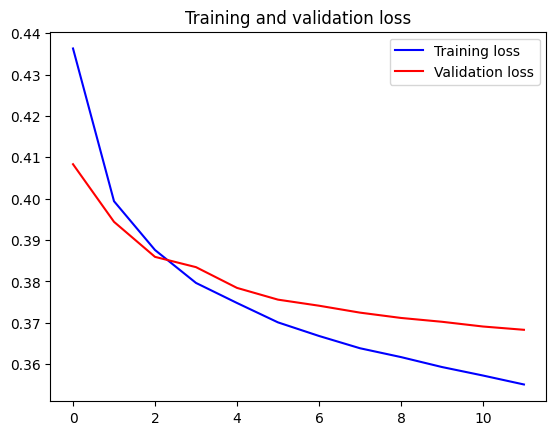

In [28]:
import matplotlib.pyplot as plt
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
# Plotting Training and Validation Metrics
# The following code visualizes the training and validation accuracy and loss over epochs.
# - The first plot displays the training accuracy (in blue) and validation accuracy (in red),
#   allowing us to observe the model's performance over time.
# - The second plot shows the training loss (in blue) and validation loss (in red),
#   which helps us understand how well the model is fitting the data and whether it is overfitting.
# This visualization aids in evaluating the model's training process and making adjustments if necessary.


In [29]:

# Function to compute and plot the Confusion Matrix
def ConfusionMatrix(y_pred, y_test):
    # Calculate the confusion matrix using true labels and predicted labels
    cf_matrix = confusion_matrix(y_test, y_pred)

    # Define the categories and group names for the confusion matrix
    categories  = ['Negative', 'Positive']
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    
    # Calculate the percentage of each group in the confusion matrix
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    # Create labels for the confusion matrix annotations
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    # Plot the confusion matrix as a heatmap
    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='',
                xticklabels=categories, yticklabels=categories)

    # Set the axis labels and title
    plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step


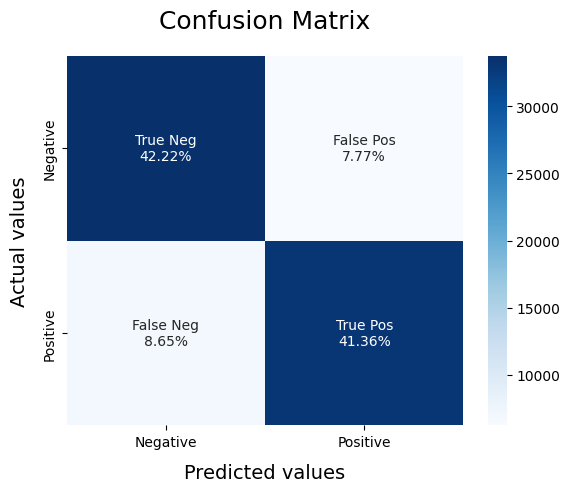

In [31]:

# Predicting on the test dataset
y_pred = training_model.predict(X_test)

# Convert predictions to binary sentiment labels (0 for Negative, 1 for Positive)
y_pred = np.where(y_pred >= 0.5, 1, 0)

# Calling the ConfusionMatrix function to display the confusion matrix
ConfusionMatrix(y_pred, y_test)


The classification report includes several important metrics:
- Precision: Indicates the accuracy of the positive predictions. A high precision means that when the model predicts a positive class (1), it is correct most of the time.
- Recall: Measures the ability of the model to find all the relevant cases (i.e., the proportion of actual positives that were identified correctly). High recall indicates that the model is good at identifying positive instances.
- F1-Score: The harmonic mean of precision and recall, which provides a single metric that balances both. A high F1-score indicates a good balance between precision and recall.
- Support: The number of actual occurrences of the class in the specified dataset, indicating how many samples there are for each class.
- Macro Avg: The average metrics calculated for each class independently, treating all classes equally.
- Weighted Avg: The average metrics calculated for each class, weighted by the number of true instances for each class. This is useful for imbalanced datasets.

In this case, both classes (0 and 1) have high precision, recall, and F1-scores around 0.84, indicating that the model performs well across both classes.


In [32]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84     39989
           1       0.84      0.83      0.83     40011

    accuracy                           0.84     80000
   macro avg       0.84      0.84      0.84     80000
weighted avg       0.84      0.84      0.84     80000



In [43]:
import pickle
import os
# Saving Word2Vec-Model
word2vec_model.wv.save('Word2Vec-twitter-100')
word2vec_model.wv.save_word2vec_format('Word2Vec-twitter-100-trainable')

# Saving the tokenizer
with open('Tokenizer.pickle', 'wb') as file:
    pickle.dump(tokenizer, file)

# Create the directory if it doesn't exist
if not os.path.exists("Model-Weights"):
    os.makedirs("Model-Weights")

# Now save the weights
training_model.save_weights("Model-Weights/weights.weights.h5")
